In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"

### Hyperparameters


In [2]:
epochs = 40
batch_size = 30
drop_out = 0.25
learning_rate = 5e-5

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=learning_rate, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.3523299875466719
Validation loss: 1.04549129651143
F1 Score (Weighted): 0.627768884999177


Epoch 2:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9176486821278281
Validation loss: 0.8862151595262381
F1 Score (Weighted): 0.7033248069990207


Epoch 3:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6836915508560513
Validation loss: 0.8063262815658863
F1 Score (Weighted): 0.7189741371042707


Epoch 4:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5317993295797403
Validation loss: 0.8899009777949407
F1 Score (Weighted): 0.7137138360546841


Epoch 5:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3873721858945446
Validation loss: 0.9851783215999603
F1 Score (Weighted): 0.7305981204376204


Epoch 6:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.3311077319625495
Validation loss: 1.1260551775877292
F1 Score (Weighted): 0.718623346876242


Epoch 7:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.2733863535458627
Validation loss: 1.1706287345060935
F1 Score (Weighted): 0.7193695963721496


Epoch 8:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.23638520017266273
Validation loss: 1.1132036484777927
F1 Score (Weighted): 0.7112443385652413


Epoch 9:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.21957261120711546
Validation loss: 1.1683758818186247
F1 Score (Weighted): 0.7160754246698814


Epoch 10:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.14730269208118535
Validation loss: 1.3770148020524244
F1 Score (Weighted): 0.7220511233542334


Epoch 11:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.15248993531787308
Validation loss: 1.3252640277720416
F1 Score (Weighted): 0.7120807743471432


Epoch 12:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.12833646371407245
Validation loss: 1.3595732628152921
F1 Score (Weighted): 0.7230057750386429


Epoch 13:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.1434360663001628
Validation loss: 1.315512783682117
F1 Score (Weighted): 0.7165783253287714


Epoch 14:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.11519656115063075
Validation loss: 1.4440045388272176
F1 Score (Weighted): 0.7319786096947084


Epoch 15:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.12310686133855926
Validation loss: 1.5041625048392093
F1 Score (Weighted): 0.7134705146079863


Epoch 16:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.09935280322637138
Validation loss: 1.523214496099032
F1 Score (Weighted): 0.7078246585380134


Epoch 17:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.08720604643104193
Validation loss: 1.5814690399341857
F1 Score (Weighted): 0.7159235283855038


Epoch 18:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.09250950540645399
Validation loss: 1.4938688318316753
F1 Score (Weighted): 0.7455966087316982


Epoch 19:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.08483182946287528
Validation loss: 1.5009038037835405
F1 Score (Weighted): 0.7384297309993834


Epoch 20:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.07164922665021774
Validation loss: 1.533254687531063
F1 Score (Weighted): 0.7269959175001486


Epoch 21:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.07918464839947748
Validation loss: 1.579678338379241
F1 Score (Weighted): 0.7415050368649515


Epoch 22:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.0770082299536823
Validation loss: 1.5563650117434848
F1 Score (Weighted): 0.7240365561122842


Epoch 23:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.057520912357005356
Validation loss: 1.5748363388702273
F1 Score (Weighted): 0.7455689363042581


Epoch 24:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.058443620875207845
Validation loss: 1.5653420698900635
F1 Score (Weighted): 0.7454477400417793


Epoch 25:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.053610363206657435
Validation loss: 1.597157240487062
F1 Score (Weighted): 0.74785079058807


Epoch 26:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.052376453584208546
Validation loss: 1.605904629955498
F1 Score (Weighted): 0.7452307143988176


Epoch 27:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.06755705447057667
Validation loss: 1.6071430699219211
F1 Score (Weighted): 0.7430525637804843


Epoch 28:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.05326883496625511
Validation loss: 1.6780476946329985
F1 Score (Weighted): 0.7346926833256188


Epoch 29:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.04060138472308661
Validation loss: 1.695742655187272
F1 Score (Weighted): 0.7269187663539617


Epoch 30:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.04152124011264844
Validation loss: 1.708557236742658
F1 Score (Weighted): 0.7487632429613333


Epoch 31:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.04336582873424893
Validation loss: 1.6407650575722352
F1 Score (Weighted): 0.7631509669581962


Epoch 32:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.0388065059104111
Validation loss: 1.650765548639286
F1 Score (Weighted): 0.7537826455954061


Epoch 33:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.04087473126718828
Validation loss: 1.6630924977720356
F1 Score (Weighted): 0.7476913369616033


Epoch 34:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.03373029150669395
Validation loss: 1.656876438225691
F1 Score (Weighted): 0.7560664733387547


Epoch 35:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.03324124876804569
Validation loss: 1.6753498239693447
F1 Score (Weighted): 0.7533253061669022


Epoch 36:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 36
Training loss: 0.0263220993519349
Validation loss: 1.679079736976956
F1 Score (Weighted): 0.7431021155300993


Epoch 37:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 37
Training loss: 0.031336638211792306
Validation loss: 1.7112218268717139
F1 Score (Weighted): 0.7430389278458293


Epoch 38:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 38
Training loss: 0.03195014398332442
Validation loss: 1.7106049154132892
F1 Score (Weighted): 0.7397370872005258


Epoch 39:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 39
Training loss: 0.022349062047146286
Validation loss: 1.7106899870559573
F1 Score (Weighted): 0.7479674259729613


Epoch 40:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 40
Training loss: 0.025448858276502215
Validation loss: 1.7146581194470996
F1 Score (Weighted): 0.7423762419358214


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.627768884999177), (2, 0.7033248069990207), (3, 0.7189741371042707), (4, 0.7137138360546841), (5, 0.7305981204376204), (6, 0.718623346876242), (7, 0.7193695963721496), (8, 0.7112443385652413), (9, 0.7160754246698814), (10, 0.7220511233542334), (11, 0.7120807743471432), (12, 0.7230057750386429), (13, 0.7165783253287714), (14, 0.7319786096947084), (15, 0.7134705146079863), (16, 0.7078246585380134), (17, 0.7159235283855038), (18, 0.7455966087316982), (19, 0.7384297309993834), (20, 0.7269959175001486), (21, 0.7415050368649515), (22, 0.7240365561122842), (23, 0.7455689363042581), (24, 0.7454477400417793), (25, 0.74785079058807), (26, 0.7452307143988176), (27, 0.7430525637804843), (28, 0.7346926833256188), (29, 0.7269187663539617), (30, 0.7487632429613333), (31, 0.7631509669581962), (32, 0.7537826455954061), (33, 0.7476913369616033), (34, 0.7560664733387547), (35, 0.7533253061669022), (36, 0.7431021155300993), (37, 0.7430389278458293), (38, 0.7397370872005258), (39, 0.7479674259729613)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.5978012179213549, 1), (0.6548586834474227, 2), (0.6745592268313843, 3), (0.6797020371487593, 4), (0.693278420341016, 5), (0.6866062733691424, 6), (0.6806401316422281, 7), (0.6712529357571048, 8), (0.6850022929585825, 9), (0.6910014926338336, 10), (0.6749659753287932, 11), (0.682578322800551, 12), (0.6736324299162169, 13), (0.6856042960330694, 14), (0.6795754602911074, 15), (0.6696301101541243, 16), (0.6716385516325424, 17), (0.7152677838816571, 18), (0.6950093419992824, 19), (0.6820939441267218, 20), (0.6988270416218715, 21), (0.6794796047798822, 22), (0.7009596151768401, 23), (0.7072980430673685, 24), (0.7085235943715391, 25), (0.7049756302987084, 26), (0.7027013163883186, 27), (0.6920850613229467, 28), (0.6882283248505238, 29), (0.7077294086201906, 30), (0.7218895049991131, 31), (0.7171923828849819, 32), (0.7083668545596269, 33), (0.7179853269198991, 34), (0.7151117637015082, 35), (0.7044585537211328, 36), (0.7026197281228453, 37), (0.7009857411947408, 38), (0.7083668545596269, 3

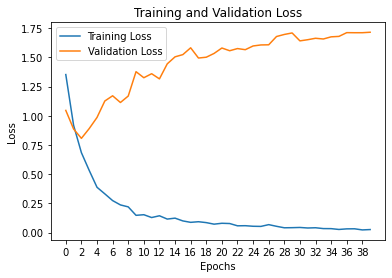

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()